# Detecting MCSs in CESM using pretrained U-Net

Software by Maria J. Molina (UMD/NCAR) for Mary Grace Albright (UConn)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
# open files
ds_flut = xr.open_dataset(
    '/glade/scratch/malbright/cesm_era5/pi_files/3H/flut/'\
    'b.e13.B1850C5CN.ne120_g16.tuning.005.cam.h4.FLUT.0057020100-0057052100.remap.nc')

ds_q850 = xr.open_dataset(
    '/glade/scratch/malbright/cesm_era5/pi_files/3H/q850/'\
    'b.e13.B1850C5CN.ne120_g16.tuning.005.cam.h4.Q850.0057020100-0057052100.remap.nc')

In [3]:
# grab variables
ds_flut = ds_flut['FLUT']
ds_q850 = ds_q850['Q850']

In [4]:
# filter months of interest (an example)
ds_flut = ds_flut[(ds_flut['time.month']>=5) & (ds_flut['time.month']<=6)]
ds_q850 = ds_q850[(ds_q850['time.month']>=5) & (ds_q850['time.month']<=6)]

In [5]:
# grab region of interest
ds_flut = ds_flut.sel(lat=slice(20,50),lon=slice(-120+360,-70+360))
ds_q850 = ds_q850.sel(lat=slice(20,50),lon=slice(-120+360,-70+360))

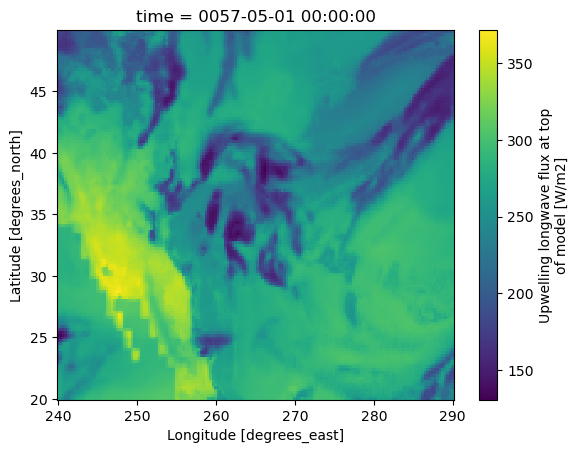

In [6]:
# quick viz to check
ds_flut.isel(time=0).plot()

In [7]:
# add channels dim and reshape
ds_flut = ds_flut.expand_dims(dim='channel').transpose('time', 'channel', 'lat', 'lon')
ds_q850 = ds_q850.expand_dims(dim='channel').transpose('time', 'channel', 'lat', 'lon')

In [8]:
# assemble data array in (samples, channels, lat, lon) order
ds_cesm = xr.concat([ds_flut, ds_q850], dim='channel')

In [9]:
print(ds_cesm.shape) # double check shape is (samples, channels, lat, lon)

(249, 2, 128, 161)


In [10]:
da_cesm = ds_cesm.values # convert to numpy array

In [11]:
import dataset_cesm   # new dataset class for cesm data

In [12]:
testing_generator = dataset_cesm.CesmDataset(
                                        cesm_array=da_cesm, 
                                        batch_size=1, 
                                        n_classes=2, 
                                        shuffle=False, 
                                        norm='zscore')

test_load = DataLoader(testing_generator, batch_size=1, shuffle=False, drop_last=False)

In [13]:
# double checking shape (batch, samples, channels, lat, lon)
for i in test_load:
    print(i['train'].shape)
    break

torch.Size([1, 1, 2, 128, 161])


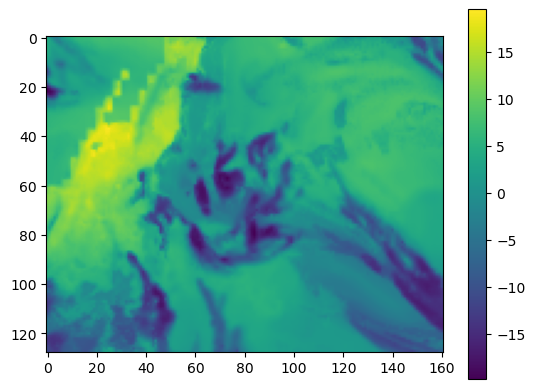

In [14]:
# double checking normalization worked (colorbar values)
for i in test_load:
    im=plt.imshow(i['train'][0,0,0,:,:])
    plt.colorbar(im)
    plt.show()
    break

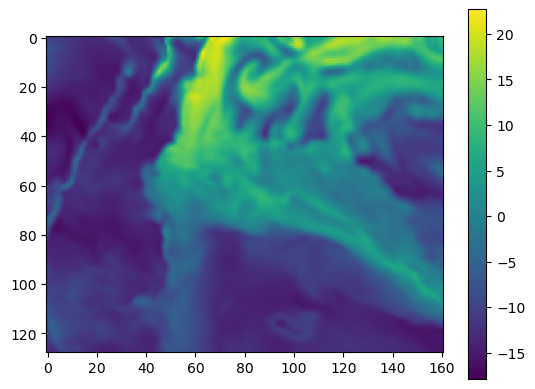

In [15]:
# double checking normalization worked (colorbar values)
for i in test_load:
    im=plt.imshow(i['train'][0,0,1,:,:])
    plt.colorbar(im)
    plt.show()
    break

In [16]:
###--- should have saved your trained mcs model parameters previously (with era5) using:
###--- torch.save(model.state_dict(), PATH)

###--- now, initiate model class:

import unet

model = unet.UNet(n_channels=2, n_classes=2) # use the final settings for your model

###--- next, load your saved model parameters into the model:

# model.load_state_dict(torch.load(PATH))
# model.eval()

In [17]:
# get device and put model on there
device = unet.get_device()
print(device)
model.to(device)

cpu


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [19]:
def generate_predictions(model, torch_dataset, torch_dataloader, num_classes=2):
    
    shape_0 = len(torch_dataset.samples_indx)
    shape_1 = torch_dataset.__getitem__(0)['train'].squeeze().shape[1]
    shape_2 = torch_dataset.__getitem__(0)['train'].squeeze().shape[2]

    predictions_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    pred_labels_ = np.zeros((shape_0, num_classes, shape_1, shape_2))
    
    indx_ = []
    model.eval()
    count_ = 0
    
    m = nn.Softmax(dim=1)

    with torch.no_grad():
        
        for i, data in enumerate(torch_dataloader):
            
            # print(i)
            
            img_noisy = data['train'].squeeze(0)
            img_noisy = img_noisy.to(device)
            
            indx_.append(data['minibatch_indx'])
            
            outputs = model(img_noisy.float())
            
            outputs = m(outputs)
            
            for out_ in range(outputs.shape[0]):
                
                predictions_[count_, ...] = outputs.cpu()[out_, ...]
                
                count_ += 1
                
    indx_ = np.array([ind for i in indx_ for ind in i.numpy()])
    
    return predictions_.astype(np.float32), indx_

In [20]:
predictions_, indx_ = generate_predictions(model, testing_generator, test_load)

In [23]:
predictions_.shape  # samples, number of classes, lat, lon

(249, 2, 128, 161)

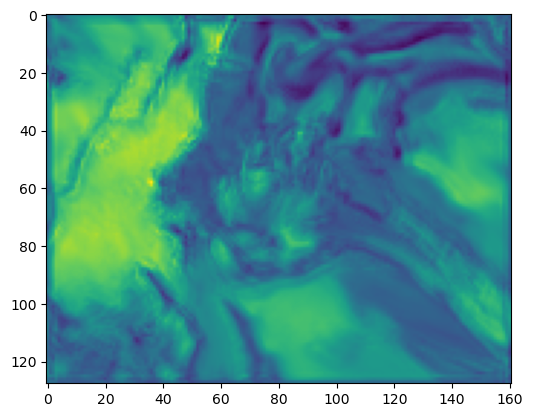

In [24]:
plt.imshow(predictions_[0,0,:,:]) # dummy prediction made with not trained unet

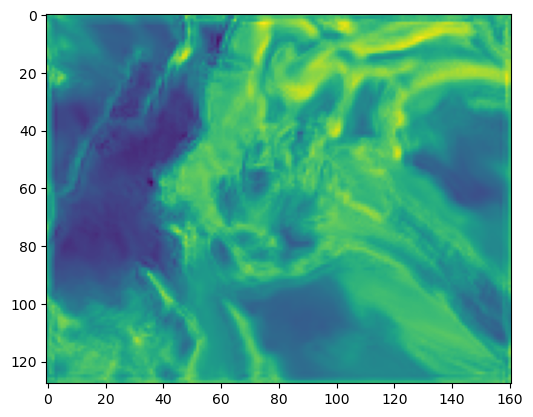

In [25]:
plt.imshow(predictions_[0,1,:,:])